In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch   
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import os 
os.environ["WANDB_DISABLED"] = "true" # tắt weight , biases logging

In [3]:
train_df=pd.read_excel("../data/train_nor_811.xlsx")
test_df=pd.read_excel("../data/test_nor_811.xlsx")
valid_df=pd.read_excel("../data/valid_nor_811.xlsx")

In [4]:
train_df.head()

,Unnamed: 0,Emotion,Sentence
0,188,Other,cho mình xin bài nhạc tên là gì với ạ
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


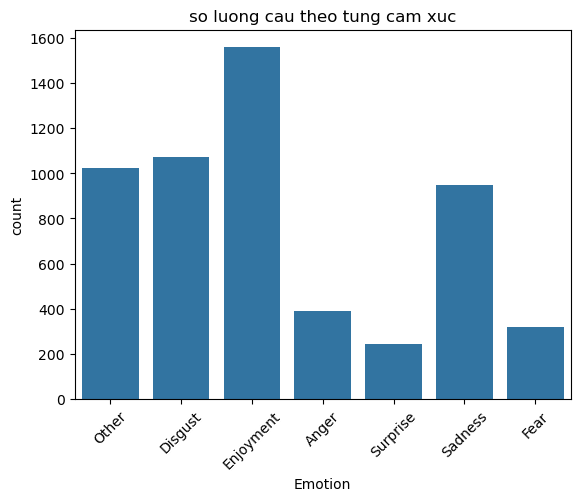

In [5]:
sns.countplot (data=train_df,x="Emotion")
plt.xticks(rotation=45)
plt.title("so luong cau theo tung cam xuc")
plt.show()

In [6]:
import re
import json
from pyvi import ViTokenizer
slang_dict = {
    "vk": "vợ", "ck": "chồng", "mk": "mình", "ib": "nhắn tin",
    "ntn": "như thế nào", "dc": "được", "ko": "không", "k": "không",
    "j": "gì", "r": "rồi", "tl": "trả lời", "lm": "làm",
    "vs": "với", "đt": "điện thoại", "fb": "facebook", "ad": "quản trị viên",
    "g9": "good night", "off": "tắt máy", "on": "bật máy", "pm": "nhắn riêng",
    "omg": "ôi trời ơi", "wtf": "cái quái gì thế", ":))":"vui vẻ","ik":"đi",
    "vl":"bất ngờ","m":"mày","t":"tao","đc":"được","cmm":"tức giận","dmm":"tức giận",
    "kkk":"hài hước"
}
with open('slang_dict.json', 'w', encoding='utf-8') as f:
    json.dump(slang_dict, f, ensure_ascii=False, indent=4)
def load_slang_dict(slang_path="slang_dict.json"):
    with open(slang_path, "r", encoding="utf-8") as f:
        return json.load(f)
def normalize_teencode(text, slang_dict):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b')
    text = pattern.sub(lambda x: slang_dict[x.group()], text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = ViTokenizer.tokenize(text)
    return text
sample_text = "ck oi, hum nay mk dc off sớm nè, ib cho vk ik "
normalized = normalize_teencode(sample_text,slang_dict)
print(f"Original: {sample_text}")
print(f"Normalized: {normalized}")

Original: ck oi, hum nay mk dc off sớm nè, ib cho vk ik 
Normalized: chồng oi , hum nay mình được tắt máy sớm nè , nhắn_tin cho vợ đi


In [7]:
train_df["Sentence"] = train_df["Sentence"].apply(lambda x: normalize_teencode(x, slang_dict))
valid_df["Sentence"] = valid_df["Sentence"].apply(lambda x: normalize_teencode(x, slang_dict))
test_df["Sentence"] = test_df["Sentence"].apply(lambda x: normalize_teencode(x, slang_dict))

In [8]:
!pip install deep-translator

In [10]:
from deep_translator import GoogleTranslator
import time

def back_translate(text):
    try:
        en_text = GoogleTranslator(source='vi', target='en').translate(text)
        vi_text = GoogleTranslator(source='en', target='vi').translate(en_text)
        return vi_text
    except Exception as e:
        print(f"Lỗi dịch: {e}")
        return text  # fallback


In [11]:


def augment_back_translation(df, label_col="Emotion", text_col="Sentence", target_class="Surprise", n_aug=3):
    df_target = df[df[label_col] == target_class]
    new_data = []

    for text in df_target[text_col]:
        for _ in range(n_aug):
            aug_text = back_translate(text)
            new_data.append({text_col: aug_text, label_col: target_class})
            time.sleep(1)  # tránh bị chặn

    return pd.concat([df, pd.DataFrame(new_data)], ignore_index=True)


In [14]:
train_df = augment_back_translation(train_df, target_class="Anger", n_aug=3)
train_df = augment_back_translation(train_df, target_class="Surprise", n_aug=3)
train_df = augment_back_translation(train_df, target_class="Fear", n_aug=3)

Lỗi dịch: hỏi lồn gì lắm thế --> No translation was found using the current translator. Try another translator?


<Axes: xlabel='Emotion', ylabel='count'>

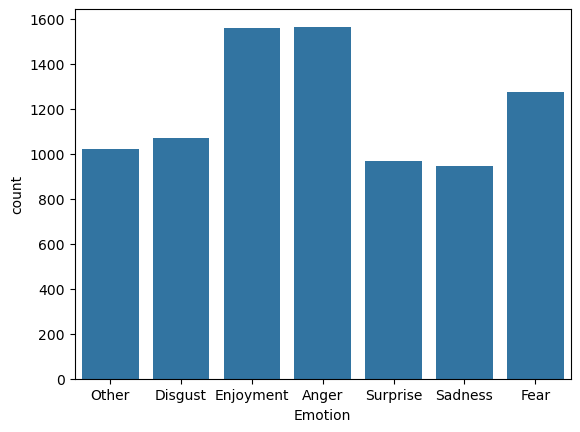

In [15]:
sns.countplot(data=train_df,x="Emotion")


In [16]:
balance_train=train_df.copy()

<Axes: xlabel='Emotion', ylabel='count'>

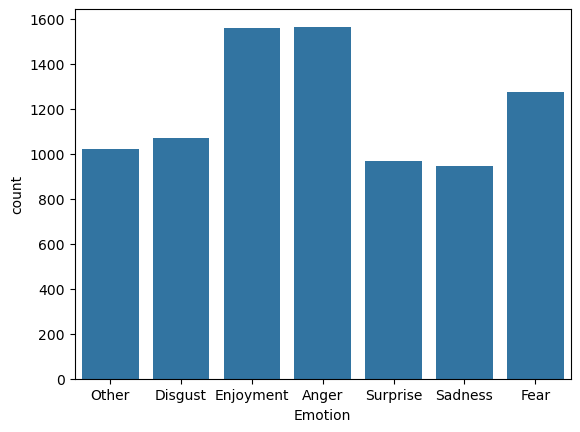

In [17]:
sns.countplot(data=balance_train,x="Emotion")

In [ ]:
balance_train.to_csv("train_backtranslate.csv", index=False)
